In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import time
import warnings
import numpy as np
import tensorflow as tf
import pandas as pd
import keras.backend as K
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras import regularizers
from matplotlib import pyplot as plt
from keras.callbacks import History 
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 10)

# prevent tensorflow from allocating the entire GPU memory at once
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
#warnings.filterwarnings("ignore") #Hide messy Numpy warnings

np.random.seed(42)

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 10)

In [4]:
# ---------------- Config params

N_EPOCHS = 8000 # 100
N_EPOCHS_MULTI = 8000 # 100

BATCH_SIZE = 128
TRAIN_PERC = 0.66

quantiles = [0.05, 0.20, 0.80, 0.95]
quantile_pairs = [(0.05, 0.95), (0.20, 0.80)]

In [5]:
# ---------------- Load data

dataset = pd.read_csv("../motorcycle.csv", sep=" ")
dataset.head()


# ---------------- Standerdize

original_series = pd.Series(dataset["y"]).as_matrix()
y_mean = original_series.mean()
y_std = original_series.std()
original_series = (original_series - y_mean) / y_std


# ---------------- Train/test split

n_train = int(TRAIN_PERC*len(original_series))

ix = np.random.permutation(len(original_series))
ix_train = ix[:n_train]
ix_train = np.array(sorted(ix_train))
print len(ix_train)
ix_test = ix[n_train:]
ix_test = np.array(sorted(ix_test))
print len(ix_test)

#X_train = lags[ix_train,:]
X_train = ix_train[:,np.newaxis]
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
print X_train.shape
y_train = original_series[ix_train]
print y_train.shape
#X_test = lags[ix_test,:]
X_test = ix_test[:,np.newaxis]
X_test = (X_test - X_mean) / X_std
print X_test.shape
y_test = original_series[ix_test]
print y_test.shape


# ---------------- Evaluation functions

def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    mse = np.mean((predicted - trues)**2)
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, mse, rae, rmse, r2


# In[7]:

def compute_error_filtered(trues, predicted, filt):
    trues = trues[filt]
    predicted = predicted[filt]
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    mse = np.mean((predicted - trues)**2)
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, mse, rae, rmse, r2


# In[8]:

def eval_quantiles(lower, upper, trues, preds):
    N = len(trues)
    icp = 1.0*np.sum((trues>lower) & (trues<upper)) / N
    diffs = np.maximum(0, upper-lower)
    mil = np.sum(diffs) / N
    rmil = 0.0
    for i in xrange(N):
        if trues[i] != preds[i]:
            rmil += diffs[i] / (np.abs(trues[i]-preds[i]))
    rmil = rmil / N
    clc = np.exp(-rmil*(icp-0.95))
    return icp, mil, rmil, clc

87
46
(87, 1)
(87,)
(46, 1)
(46,)


In [6]:
# ---------------- Linear Quantile Regression baselines

col_names = ["l%d" % (i,) for i in xrange(X_train.shape[1])]
col_names.append("y")
qr_str = "y ~ " + ''.join(["+l%d" % (x,) for x in range(X_train.shape[1])])[1:]

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
predictions_lr = regr.predict(X_test)

col_names = ["l%d" % (i,) for i in xrange(X_train.shape[1])]
col_names.append("y")
#col_names = ["x","y"]
print len(col_names)
data = pd.DataFrame(data = np.hstack([X_train, y_train[:,np.newaxis]]), columns = col_names)
print data.shape
data_test = pd.DataFrame(data = np.hstack([X_test, y_test[:,np.newaxis]]), columns = col_names)

predictions_q_lr = []
qr_str = "y ~ " + ''.join(["+l%d" % (x,) for x in range(X_train.shape[1])])[1:]
print qr_str
for k in xrange(len(quantiles)):
    q = quantiles[k]
    print "running quantile regression for quantile:", q
    
    qr = smf.quantreg(qr_str, data)
    res = qr.fit(q=q)
    predictions_q_lr.append(res.predict(data_test))


2
(87, 2)
y ~ l0
running quantile regression for quantile: 0.05
running quantile regression for quantile: 0.2
running quantile regression for quantile: 0.8
running quantile regression for quantile: 0.95


In [7]:
# ---------------- Independent deep learning models for mean and quantiles

def tilted_loss(q,y,f):
    e = (y-f)
    # The term inside k.mean is a one line simplification of the first equation
    return K.mean(q*e + K.clip(-e, K.epsilon(), np.inf), axis=-1)


def build_model(loss="mse", num_outputs=1):
    model = Sequential()

    model.add(Dense(units=50, 
                    input_shape=(X_train.shape[1],)
             ))
    model.add(Activation("tanh"))

    model.add(Dense(units=5,))
    model.add(Activation("tanh"))
    
    model.add(Dense(units=num_outputs,))
    model.add(Activation("linear"))
    
    model.compile(loss=loss, optimizer='nadam')
    
    return model


print "\nTraining NN for mean..."

model = build_model(loss="mse", num_outputs=1)

history_mean = History()

model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    #validation_split=0.0,
    validation_data=(X_test,y_test),
    callbacks=[history_mean],
    verbose=0)  

# make predictions
predictions = model.predict(X_test)


models_q = []
histories_q = []
for q in quantiles:
    print "\nTraining NN for quantile %.2f..." % (q,)
    
    history_q = History()

    # fit model to the 5% quantile
    model_q = build_model(loss=lambda y,f: tilted_loss(q,y,f))
    model_q.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=N_EPOCHS,
        #validation_split=0.0,
        validation_data=(X_test,y_test),
        callbacks=[history_q],
        verbose=0)  
    models_q.append(model_q)
    histories_q.append(history_q)


predictions_q = []
for i in xrange(len(quantiles)):
    q = quantiles[i]
    print "\nMaking predictions for quantile %.2f..." % (q,)

    # make predictions
    predictions_q.append(models_q[i].predict(X_test))
    


Training NN for mean...

Training NN for quantile 0.05...

Training NN for quantile 0.20...

Training NN for quantile 0.80...

Training NN for quantile 0.95...

Making predictions for quantile 0.05...

Making predictions for quantile 0.20...

Making predictions for quantile 0.80...

Making predictions for quantile 0.95...


In [8]:
# ---------------- Simultaneous Mean and Quantiles NN

def multi_tilted_loss(quantiles,y,f):
    #print y
    #print f
    # The term inside k.mean is a one line simplification of the first equation
    loss = K.mean(K.square(y[:,0]-f[:,0]), axis=-1)
    for k in xrange(len(quantiles)):
        q = quantiles[k]
        e = (y[:,k+1]-f[:,k+1])
        loss += K.mean(q*e + K.clip(-e, K.epsilon(), np.inf), axis=-1)
    return loss


# construct multi-output for multi-quantile DL
y_traink = y_train[:,np.newaxis]
for k in xrange(len(quantiles)):
    y_traink = np.concatenate((y_traink, y_train[:,np.newaxis]), axis=1)
print y_traink.shape

y_testk = y_test[:,np.newaxis]
for k in xrange(len(quantiles)):
    y_testk = np.concatenate((y_testk, y_test[:,np.newaxis]), axis=1)
print y_testk.shape

print "\nTraining multi-quantile NN..."

history_multi = History()

# fit model to the 95% quantile
model_multi = build_model(loss=lambda y,f: multi_tilted_loss(quantiles,y,f), num_outputs=1+len(quantiles))
model_multi.fit(
    X_train,
    y_traink,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS_MULTI, 
    validation_data=(X_test,y_testk),
    callbacks=[history_multi],
    verbose=0)

# make predictions
predictions_multi = model_multi.predict(X_test)

(87, 5)
(46, 5)

Training multi-quantile NN...


In [10]:
# ---------------- Evaluate different methods

print "\nEvaluating different methods..."

# evaluate mean prediction

maes_lr = []
rmses_lr = []
r2s_lr = []
maes_dl = []
rmses_dl = []
r2s_dl = []
maes_multi = []
rmses_multi = []
r2s_multi = []

trues = y_test #* y_std + y_mean
preds_qr = predictions_lr #* y_std + y_mean
preds_dl = predictions[:,0] #* y_std + y_mean
preds_multi = predictions_multi[:,0] #* y_std + y_mean

# evaluate prediction means
s = "[%d]\tMean:" % (i,)
corr, mae, mse, rae, rmse, r2 = compute_error(trues, preds_qr)
maes_lr.append(mae)
rmses_lr.append(rmse)
r2s_lr.append(r2)
s += "\t(QR: %.2f %.2f %.2f)" % (mae,rmse,r2)
corr, mae, mse, rae, rmse, r2 = compute_error(trues, preds_dl)
maes_dl.append(mae)
rmses_dl.append(rmse)
r2s_dl.append(r2)
s += "\t(DLQR: %.2f %.2f %.2f)  " % (mae,rmse,r2)
corr, mae, mse, rae, rmse, r2 = compute_error(trues, preds_multi)
maes_multi.append(mae)
rmses_multi.append(rmse)
r2s_multi.append(r2)
s += "\t(MULTI: %.2f %.2f %.2f)" % (mae,rmse,r2)
#print s

print "ERRORS:"
print "\tMAE\tRMSE\tR2"
print "LR:    %.3f %.3f %.3f" % (np.mean(maes_lr),np.mean(rmses_lr),np.mean(r2s_lr)) 
print "DL:    %.3f %.3f %.3f" % (np.mean(maes_dl),np.mean(rmses_dl),np.mean(r2s_dl)) 
print "MULTI: %.3f %.3f %.3f" % (np.mean(maes_multi),np.mean(rmses_multi),np.mean(r2s_multi)) 


Evaluating different methods...
ERRORS:
	MAE	RMSE	R2
LR:    0.865 1.090 0.078
DL:    0.482 0.647 0.675
MULTI: 0.375 0.502 0.804


In [11]:
def smooth(vec, factor=2):
    vec = np.array(vec)
    new_vec = np.zeros(int(len(vec) / factor)-1)
    for i in range(0,len(vec)-factor,factor):
        #print(len(vec[i:(i+factor)]))
        new_vec[i/factor] = vec[i:(i+factor)].mean()
    return new_vec

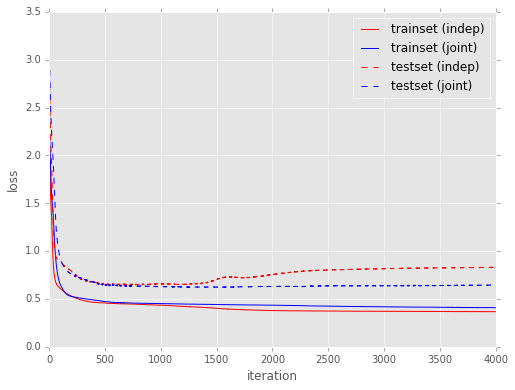

In [14]:
plt.figure(figsize=(8,6))
#plt.plot(history_mean.history["loss"])
plt.plot(smooth(np.array([history_mean.history["loss"]] + [h.history["loss"] for h in histories_q]).sum(axis=0)), "r-")
plt.plot(smooth(history_multi.history["loss"]), "b-")
plt.plot(smooth(np.array([history_mean.history["val_loss"]] + [h.history["val_loss"] for h in histories_q]).sum(axis=0)), "r--")
plt.plot(smooth(history_multi.history["val_loss"]), "b--")
plt.legend(["trainset (indep)","trainset (joint)","testset (indep)","testset (joint)"])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig("losses_motorcycle.pdf")
plt.show()

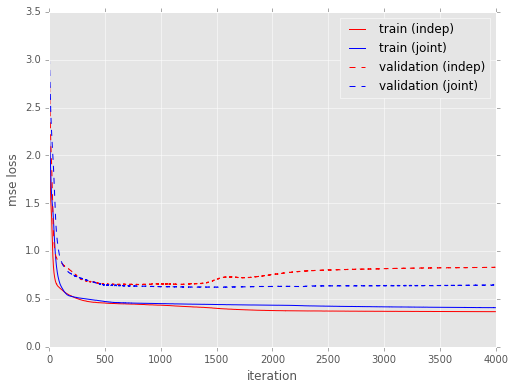

In [199]:
plt.figure(figsize=(8,6))
#plt.plot(history_mean.history["loss"])
plt.plot(smooth(np.array([history_mean.history["loss"]] + [h.history["loss"] for h in histories_q]).sum(axis=0)), "r-")
plt.plot(smooth(history_multi.history["loss"]), "b-")
plt.plot(smooth(np.array([history_mean.history["val_loss"]] + [h.history["val_loss"] for h in histories_q]).sum(axis=0)), "r--")
plt.plot(smooth(history_multi.history["val_loss"]), "b--")
plt.legend(["train (indep)","train (joint)","validation (indep)","validation (joint)"])
plt.xlabel("iteration")
plt.ylabel("mse loss")
plt.savefig("losses_motorcycle.eps")
plt.show()

In [162]:
# evaluate crossing quantiles

loss_qr = 0.0
loss_dl = 0.0
loss_multi = 0.0
for k in xrange(len(quantiles)-1):
    q1 = predictions_q_lr[k]
    q2 = predictions_q_lr[k+1]
    loss_qr += np.sum(np.maximum(0.0, q1 - q2)) / len(q1)

    q1 = predictions_q[k][:,0]# * removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]
    q2 = predictions_q[k+1][:,0]# * removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]
    loss_dl += np.sum(np.maximum(0.0, q1 - q2)) / len(q1)

    q1 = predictions_multi[:,1+k]# * removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]
    q2 = predictions_multi[:,1+k+1]# * removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]
    loss_multi += np.sum(np.maximum(0.0, q1 - q2)) / len(q1)

print "CROSS LOSS QR:", loss_qr
print "CROSS LOSS DL:", loss_dl
print "CROSS LOSS MULTI:", loss_multi


sum_qr = 0
sum_dl = 0
sum_multi = 0
for k in xrange(len(quantiles)-1):
    loss_qr = np.sum(predictions_q_lr[k] > predictions_q_lr[k+1])
    sum_qr += loss_qr
    loss_dl = np.sum(predictions_q[k][:,0] > predictions_q[k+1][:,0])
    sum_dl += loss_dl
    loss_multi = np.sum(predictions_multi[:,1+k] > predictions_multi[:,1+k+1])
    sum_multi += loss_multi
    #print "[%d-%d] crossing cases: QR: %d\tDL: %d\t  MULTI: %d" % (k,k+1,loss_qr,loss_dl,loss_multi)

print "NUM CROSSES QR:", sum_qr
print "NUM CROSSES DL:", sum_dl
print "NUM CROSSES MULTI:", sum_multi


# evaluate tilted losses

def tilted_loss_np(q,y,f):
    e = (y-f)
    # The term inside k.mean is a one line simplification of the first equation
    return np.mean(q*e + np.clip(-e, K.epsilon(), np.inf), axis=-1)

sum_qr = 0
sum_dl = 0
sum_multi = 0
for k in xrange(len(quantiles)):
    trues = y_test[:]# * removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]

    preds_qr = predictions_lr #* matrix_std[i,j] + matrix_trend[n_train:n_test,i,j]
    quant_qr = predictions_q_lr[k].values #* matrix_std[i,j] + matrix_trend[n_train:n_test,i,j]

    preds_dl = predictions[:,0] #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]
    quant_dl = predictions_q[k][:,0] #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]

    preds_multi = predictions_multi[:,0] #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]
    quant_multi = predictions_multi[:,k+1] #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]

    sum_qr += tilted_loss_np(quantiles[k],trues,quant_qr)
    sum_dl += tilted_loss_np(quantiles[k],trues,quant_dl)
    sum_multi += tilted_loss_np(quantiles[k],trues,quant_multi)

print "TILTED LOSS QR:", sum_qr
print "TILTED LOSS DL:", sum_dl
print "TILTED LOSS MULTI:", sum_multi

CROSS LOSS QR: 0.0
CROSS LOSS DL: 0.02426771236502606
CROSS LOSS MULTI: 0.003439410873081373
NUM CROSSES QR: 0
NUM CROSSES DL: 5
NUM CROSSES MULTI: 7
TILTED LOSS QR: 0.8378589462703411
TILTED LOSS DL: 0.4153842244924335
TILTED LOSS MULTI: 0.39381460887005887


In [163]:
# evaluate quantiles

for pair in quantile_pairs:
    q_low, q_high = pair
    q_low_ix = quantiles.index(q_low)
    q_high_ix = quantiles.index(q_high)

    icps_qr = []
    mils_qr = []
    rmils_qr = []
    icps_dl = []
    mils_dl = []
    rmils_dl = []
    icps_multi = []
    mils_multi = []
    rmils_multi = []
    
    trues = y_test #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]

    preds_qr = predictions_lr #* matrix_std[i,j] + matrix_trend[n_train:n_test,i,j]
    lower_qr = predictions_q_lr[q_low_ix] #* matrix_std[i,j] + matrix_trend[n_train:n_test,i,j]
    upper_qr = predictions_q_lr[q_high_ix] #* matrix_std[i,j] + matrix_trend[n_train:n_test,i,j]

    preds_dl = predictions[:,0] #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]
    lower_dl = predictions_q[q_low_ix][:,0] #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]
    upper_dl = predictions_q[q_high_ix][:,0] #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]

    preds_multi = predictions_multi[:,0] #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]
    lower_multi = predictions_multi[:,q_low_ix+1] #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]
    upper_multi = predictions_multi[:,q_high_ix+1] #* removed_std_all[i][i_val:i_test] + removed_seasonality_all[i][i_val:i_test]

    # evaluate quantiles
    s = "[%d]\tQuantiles:" % (i,)
    icp, mil, rmil, clc = eval_quantiles(lower_qr, upper_qr, trues, preds_qr)
    icps_qr.append(icp)
    mils_qr.append(mil)
    rmils_qr.append(rmil)
    s += "\t(QR: %.2f %.2f %.2f)" % (icp, mil, rmil)
    icp, mil, rmil, clc = eval_quantiles(lower_dl, upper_dl, trues, preds_dl)
    icps_dl.append(icp)
    mils_dl.append(mil)
    rmils_dl.append(rmil)
    s += "\t(DLQR: %.2f %.2f %.2f)  " % (icp, mil, rmil)
    icp, mil, rmil, clc = eval_quantiles(lower_multi, upper_multi, trues, preds_multi)
    icps_multi.append(icp)
    mils_multi.append(mil)
    rmils_multi.append(rmil)
    s += "\t(MULTI: %.2f %.2f %.2f)" % (icp, mil, rmil)
    #print s

    print "QUANTILES (MEAN):"
    print "QR:    %.3f %.3f %.3f" % (np.mean(icps_qr),np.mean(mils_qr),np.mean(rmils_qr)) 
    print "DLQR:  %.3f %.3f %.3f" % (np.mean(icps_dl),np.mean(mils_dl),np.mean(rmils_dl)) 
    print "MULTI: %.3f %.3f %.3f" % (np.mean(icps_multi),np.mean(mils_multi),np.mean(rmils_multi)) 

    print "QUANTILES (MEDIAN):"
    print "QR:    %.3f %.3f %.3f" % (np.median(icps_qr),np.median(mils_qr),np.median(rmils_qr)) 
    print "DLQR:  %.3f %.3f %.3f" % (np.median(icps_dl),np.median(mils_dl),np.median(rmils_dl)) 
    print "MULTI: %.3f %.3f %.3f" % (np.median(icps_multi),np.median(mils_multi),np.median(rmils_multi)) 

QUANTILES (MEAN):
QR:    0.848 3.317 74.457
DLQR:  0.783 1.398 5.376
MULTI: 0.761 1.321 15.048
QUANTILES (MEDIAN):
QR:    0.848 3.317 74.457
DLQR:  0.783 1.398 5.376
MULTI: 0.761 1.321 15.048
QUANTILES (MEAN):
QR:    0.500 1.460 37.605
DLQR:  0.543 0.796 2.832
MULTI: 0.500 0.725 7.504
QUANTILES (MEDIAN):
QR:    0.500 1.460 37.605
DLQR:  0.543 0.796 2.832
MULTI: 0.500 0.725 7.504
